In [2]:
# X Gaussian Mixture Models

# Die nicht-probabilistische Vorhergehensweise beim k-Means Clustering (Zuordnung basiert lediglich auf der Nähe zu den 
# Clusterzentren und nicht auf Verteilungslogik) führt oft zu einer schlechteren Funktionsweise in realen Szenarien

# Gaussian Mixture Modelle können als Erweiterung des k-Means Ansatzes verstanden werden, können jedoch auch ein mächtiges 
# Tool über Clustering hinaus sein

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns; sns.set()

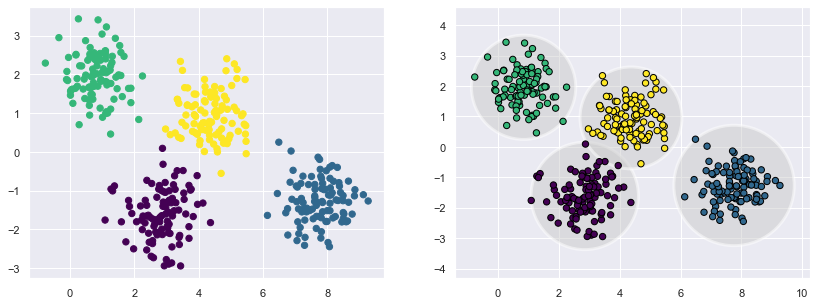

In [28]:
# Schwäche von k-Means
from sklearn.datasets import make_blobs

X, y_true = make_blobs(n_samples = 400, centers=4,
                      cluster_std = 0.6, random_state=0)

X = X[:, ::-1] # dreht Achsen um (::-1 nimmt der Reihe nach, die letzte Achse)
# >> bessere VIsualisierung

from sklearn.cluster import KMeans
kmeans = KMeans(4, random_state=0)
labels = kmeans.fit(X).predict(X)

fig = plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.scatter(X[:,0], X[:,1], c=labels, s=40, cmap="viridis")

# Aufgrund der Visualisierung könnte man annehmen, dass die Zuordnung zu einem gewissen Cluster bei manchen Punkten
# 'sicherer'/wahrscheinlicher ist als bei andere >> kMeans hat jedoch keine Metrik dafür...
# >> um diese Wahrscheinlichkeit zu bestimmen müsste die Analyse mit einem boostrap-sample wiederholt werden
# >> Eine Möglichkeit das zu verdeutlichen ist über die Visualisierung eines Kreises vom Zentrum der Cluster mit dem
#    Radius der Distanz zum weitesten Punkt

from scipy.spatial.distance import cdist

def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)
    
    # plot input Date
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:,0], X[:,1], edgecolors = "black", c=labels, s=40, cmap='viridis', zorder=2)
    
    # plot the representation of k-means model
    centers = kmeans.cluster_centers_
    # bestimmen der max Distanz von Punkte mit einem gewissen Label und dem dazugehörigen Center
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))

plt.subplot(1, 2, 2)
plot_kmeans(kmeans,X)

C:\Users\Manue\AppData\Local\Temp\ipykernel_12544\3783655440.py:28: RuntimeWarning: invalid value encountered in sqrt
  x[:, 1] = np.sqrt(b**2 - a**2/b**2*x[:,0]**2)


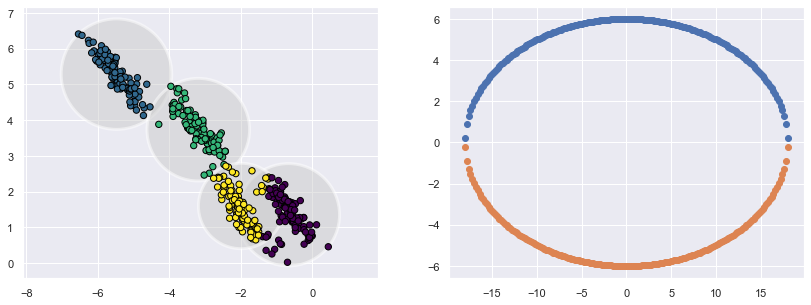

In [59]:
# Wichtig ist, dass das Cluster-Modell von kMeans kreisförmig sein muss (da Anordnung um das Clusterzentrum)
# >> Dies führt zu Problemen, wenn die CLuster nicht zirkulär sind

rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2,2))

kmeans = KMeans(n_clusters=4, random_state=0)

fig = plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plot_kmeans(kmeans, X_stretched)

# KMeans versucht diese eindeutig ellipsenförmigen Cluster in kreisförmige Cluster zu "zwingen", was jedoch zu einem 
# Überlappen der Zuordnung führt.
# >> Während dieses Problem mit einer PCA angegangen werden könnte, besteht keine Garantie, dass dies tatsächlich zu einer 
#    Lösung führt

# Um die beiden Probleme (keine Einschätzung der Sicherheit der Zuordnung und zirkuläre Cluster) anzugehen, müsste das Modell
# generalisiert werden und Beispielsweise die Distanz zu allen Clustern berücksichtigt und ellipsenförmige Cluster betrachtet
# werden


# Ellipsen zeichnen - just for fun
def draw_elipses(a, b):
    # generate Data
    x = np.zeros((200, 2))
    x[:, 0] = np.linspace(-20, 20, 200)
    x[:, 1] = np.sqrt(b**2 - a**2/b**2*x[:,0]**2)
    
    # Die Ellipse Zeichnen
    plt.scatter(test[:, 0], test[:,1 ])
    plt.scatter(test[:, 0], test[:,1 ]*-1)
    pass


plt.subplot(1, 2, 2)
draw_elipses(2, 4)

[[0.    0.469 0.    0.531]
 [1.    0.    0.    0.   ]
 [1.    0.    0.    0.   ]
 [0.    0.    0.    1.   ]
 [1.    0.    0.    0.   ]]


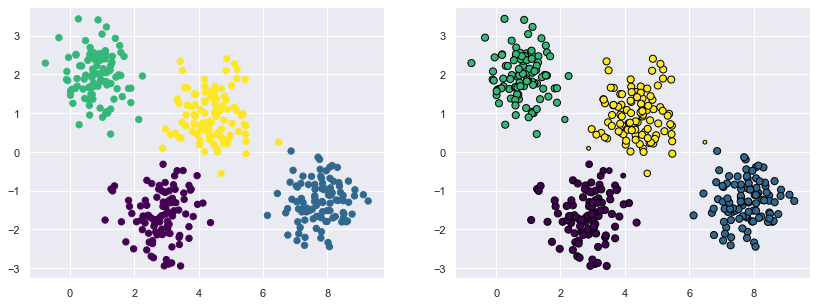

In [69]:
# X Gaussian Mixture Modells (GMM)
# Das betrachten von ellipsenförmigen Clustern und Einbezug der Distanz zu allen Clusterzentren ist ein zentraler Aspekt für 
# Gaussian Mixture Modelle

# GMM versucht einen Mix aus multidimensionalen Gaussischen Wahrscheinlichkeitsverteilungen zu finden, die die Input-Daten
# bestmöglich beschreiben (als einfaches Anwendungsfeld können damit Cluster, wie bei kMeans gefunden werden)
# > Dabei funktioniert es relativ ähnlich, wie kMeans und verwendet einen Expectation-Maximization Ansatz

# Der Hyperparameter covariance_type sollte sorgfältig gewählt werden, da er den Grad an Freiheit für die Form
# jedes Clusters bestimmt.
# - 'diag' (Deault): bedeuted, dass die Größe jedes Clusters auf den Dimensionen unabhängig voneinander bestimmt werden kann
#    > die resultierenden Ellipsen werden jedoch mit der X- und Y-Achse aligned
# - 'spherical': bestimmt, dass die Form der Cluster entlang der Dimension gleich ist > hat kreisförmige Cluster zur Folge
# - 'full': erlaubt das Modellieren einer Ellipse mit freier Rotierung >> ist allerdings rechenintensiv


# Vorgehensweise
# a) Rate Lage und Form
# b) Wiederhole bis sich der nächste Schritt dem vorherhigen annährt
#    E: Für jeden Punkt werden Gewichte festgelegt, die die Wahrscheinlichkeit der Clusterzugehörigkeit bestimmen
#    M: Updaten der Lage, Normalisierung und Form jedes Clusters basierend auf den Gewichten

from sklearn.mixture import GaussianMixture
# Objekt erstellen und Modell fitten
gmm = GaussianMixture(n_components=4).fit(X)
# Vorhersage
labels = gmm.predict(X)
# Visualisierung
fig = plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap="viridis")


# - Vorhersagewahrscheinlichkeiten
# Da es sich um ein probabilistisches Modell handelt, gibt es zu jeder Clusterzuordnung eine Wahrscheinlichkeit
probs = gmm.predict_proba(X)
print(probs[:5].round(3))
# Beispielsweise wird der erste Punkt Cluster 4 zugeordnet, auch wenn er mit einer Wahrscheinlichkeit von 46.3% Cluster 1 
# zugeordnet werden könnte
# >> diese Wahrscheinlichkeit könnte auch visualisiert werden

size = 50 * probs.max(1) ** 2
plt.subplot(1, 2, 2)
plt.scatter(X[:, 0], X[:, 1], edgecolors="black", c=labels, cmap='viridis', s=size)

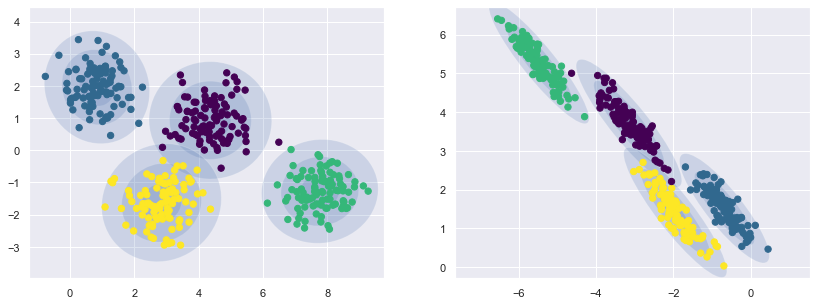

In [96]:
# Funktion zum Visualiseren der Lage und Form von GMM CLustern
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an allipse with a given position and covariance"""
    
    ax = ax or plt.gca()
    
    # Konvertiere Kovarianz zu principal axes
    if covariance.shape == (2,2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
        
    # Draw the ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height, 
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)
        
gmm = GaussianMixture(n_components=4, random_state=42)

# Visualisierung des Modells
fig = plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plot_gmm(gmm, X)

# Visualisierung des Strechted Datensatzes
gmm = GaussianMixture(n_components=4, covariance_type='full', random_state=42)
plt.subplot(1, 2, 2)
plot_gmm(gmm, X_stretched)

# Der Hyperparameter covariance_type sollte sorgfältig gewählt werden, da er den Grad an Freiheit für die Form
# jedes Clusters bestimmt.
# - 'diag' (Deault): bedeuted, dass die Größe jedes Clusters auf den Dimensionen unabhängig voneinander bestimmt werden kann
#    > die resultierenden Ellipsen werden jedoch mit der X- und Y-Achse aligned
# - 'spherical': bestimmt, dass die Form der Cluster entlang der Dimension gleich ist > hat kreisförmige Cluster zur Folge
# - 'full': erlaubt das Modellieren einer Ellipse mit freier Rotierung >> ist allerdings rechenintensiv

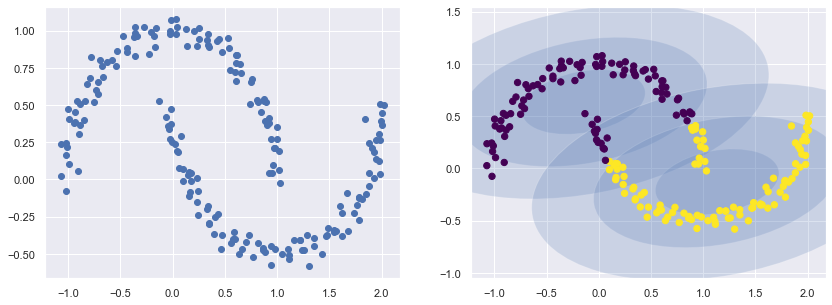

In [104]:
# X GMM as density Estimation

# Obwohl GMM häufig als Clusteralgorithmus kategorisiert wird, ist es eigentlich eine density Estimation
from sklearn.datasets import make_moons

Xmoon, ymoon = make_moons(200, noise=.05, random_state=0)

# Visualisierung der Punkte
fig = plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.scatter(Xmoon[:,0], Xmoon[:,1])

# Versuch diesen Zusammenhang mit einem zwei Komponenten GMM vorherzusagen
plt.subplot(1, 2, 2)
gmm2 = GaussianMixture(n_components=2, covariance_type='full', random_state=0)
plot_gmm(gmm2, Xmoon)

# In dem Fall ist das ERgebnis wenig nützlich

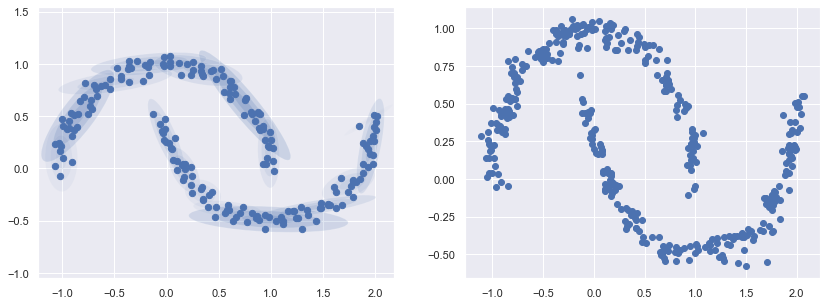

In [127]:
fig = plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)

# Modell mit 16 Komponente
gmm16 = GaussianMixture(n_components=16, covariance_type='full', random_state=0)
plot_gmm(gmm16, Xmoon, label=False)

# Wenn stattdessen allerdings mehr Komponenten gefittet werden und Cluster label ignoriert werden,
# wird ein fit gefunden, der die Daten deutlich besser widerspiegelt

# >> in dem Fall wird GMM nicht verwendet, um Cluster zu finden, sondern die übergeordnete Verteilung
# >> dabei handelt es sich um ein generatives Modell mit dem neue Punkte zufällig erstellt werden können, die zur Verteilung passen


# Zufallswerte von dem Modell
Xnew = gmm16.sample(400)[0]
plt.subplot(1, 2, 2)

plt.scatter(Xnew[:, 0], Xnew[:, 1])

# >> auf diese Art können multidimensionale Verteilungen einfach nachgebaut werden

C:\Users\Manue\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Text(0.5, 0, 'n_components')

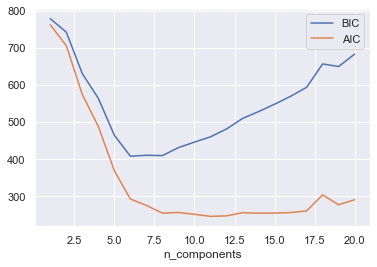

In [131]:
# Dabei stellt sich die Frage nach der optimalen Anzahl der Komponenten für das Modell
# Dies kann einfach mit Crossvalidierung herausgefunden werden

n_components = np.arange(1, 21)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(Xmoon) 
         for n in n_components]

plt.plot(n_components, [m.bic(Xmoon) for m in models], label='BIC')
plt.plot(n_components, [m.aic(Xmoon) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')

# >> Die optimale Anzahl minimiert AIC und BIC >> also läge diese ca. bei 8

(1797, 64)
(1797, 41)


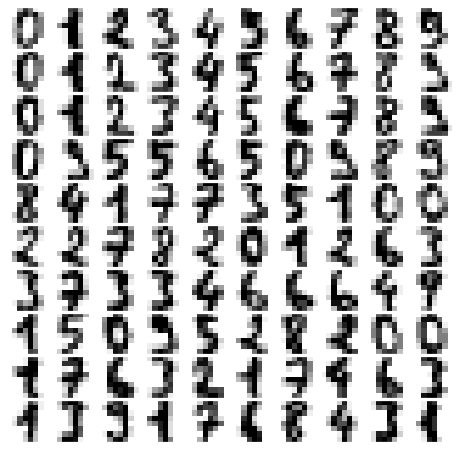

In [140]:
# X Anwendungsbeispiel GMM zum generieren neuer Daten
# Hier werden neue Bilder von Handgeschriebenen Zahlen mit dem digits Datensatz generiert

from sklearn.datasets import load_digits
digits = load_digits()
print(digits.data.shape)

# Funktion zum Zeichnen der Zahlen
def plot_digits(data):
    fig, ax = plt.subplots(10, 10, figsize=(8,8),
                          subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(8, 8), cmap='binary')
        im.set_clim(0, 16)
        
plot_digits(digits.data)

# Verdichten der Daten mit einem umkehrbaren Algorithmus zur Dimensionsreduzierung
# hier wird PCA verwendet >> leichter für GMM mit weniger DImensionen zu arbeiten
from sklearn.decomposition import PCA
pca = PCA(0.99, whiten=True)
data = pca.fit_transform(digits.data)
print(data.shape)

True


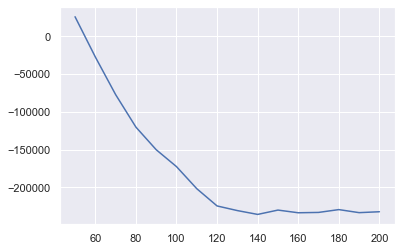

In [144]:
# Als nächster wird der AIC verwendet um herauszufinden, wie viele Komponente für das generative Modell genutzt werden sollen
n_components = np.arange(50, 210, 10)
models = [GaussianMixture(n, covariance_type='full', random_state=0) 
         for n in n_components]
aics = [model.fit(data).aic(data) for model in models]
plt.plot(n_components, aics)

# Bei 140 Komponenten bester fit
gmm = GaussianMixture(140, covariance_type='full', random_state=0)
gmm.fit(data)
print(gmm.converged_)

[  1   2   3   4   5   6   7   7   8   8   8   9  10  10  11  13  13  17
  17  18  18  19  20  20  21  22  23  25  27  31  32  35  37  38  38  38
  39  40  42  44  45  49  50  52  52  52  56  66  66  68  68  68  70  70
  70  70  71  72  72  72  74  80  81  88  89  89  93  93  96  98  98 100
 102 102 102 103 103 105 106 109 109 109 111 112 112 114 114 116 117 118
 119 122 122 123 130 134 135 136 137 138]
(100, 41)


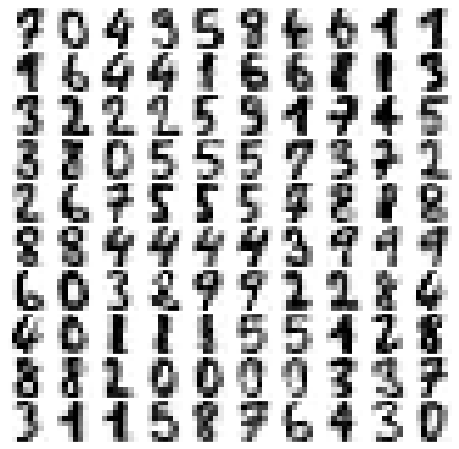

In [151]:
# nun können neue Beispiele gezeichnet werden
data_new = gmm.sample(100)[0]
print(data_new.shape) # müssen noch reverse transformed werden

digits_new = pca.inverse_transform(data_new)
plot_digits(digits_new) # KI generierte Zahlen oOo